In [1]:
from pathlib import Path
from typing import List, Dict, Tuple, Optional, Union, Generator

import math
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from descriptive_stats import *
from helpers import iter_lines
from complex_radar import ComplexRadarChart, build_radar_chart

In [2]:
random.seed(42) # for reproducibility

In [3]:
keep_cols = {
    'first_order_coherence': 'First order coherence',
    'second_order_coherence': 'Second order coherence',
    'entropy': 'Entropy',
    # 'perplexity': 'Perplexity',
    # 'per_word_perplexity': 'Perplexity (per word)',
    'pos_prop_PROPN': 'Proportion of PROPN',
    'pos_prop_PUNCT': 'Proportion of PUNCT',
    'pos_prop_SCONJ': 'Proportion of SCONJ',
    'pos_prop_PRON': 'Proportion of PRON',
    'pos_prop_AUX': 'Proportion of AUX',
    # 'pos_prop_ADP': 'Proportion of ADP',
    'pos_prop_VERB': 'Proportion of VERB',
    'pos_prop_CCONJ': 'Proportion of CCONJ',
    'pos_prop_NOUN': 'Proportion of NOUN',
    'pos_prop_ADV': 'Proportion of ADV',
    'pos_prop_ADJ': 'Proportion of ADJ',
    # 'pos_prop_DET': 'Proportion of DET',
    # 'pos_prop_SPACE': 'Proportion of SPACE',
    # 'pos_prop_PART': 'Proportion of PART',
    # 'pos_prop_NUM': 'Proportion of NUM',
    'token_length_mean': 'Token length',
    # 'token_length_median': 'Median token length',
    # 'token_length_std': 'Std. token length',
    'sentence_length_mean': 'Sentence length',
    # 'sentence_length_median': 'Median sentence length',
    # 'sentence_length_std': 'Std. sentence length',
    # 'syllables_per_token_mean': 'Avg. syllable per token',
    # 'syllables_per_token_median': 'Median syllable per token',
    # 'syllables_per_token_std': 'Std. syllables per token',
    # 'n_tokens': 'Number of tokens',
    # 'n_unique_tokens': 'Number of unique tokens',
    'proportion_unique_tokens': 'Proportion of unique tokens',
    # 'n_characters': 'Number of characters',
    'n_sentences': 'Number of sentences',
    # 'passed_quality_check': 'Quality check',
    'n_stop_words': 'Number of stop words',
    # 'alpha_ratio': 'Alpha Ratio',
    # 'mean_word_length': 'Avg. word length',
    'doc_length': 'Document length',
    # 'symbol_to_word_ratio_#': 'Symbol to word ratio',
    # 'proportion_ellipsis': 'Proportion of ellipsis',
    # 'proportion_bullet_points': 'Proportion of bullet points',
    # 'contains_lorem ipsum': 'Contains lorem ipsum',
    # 'duplicate_line_chr_fraction': 'Duplicate lines character fraction',
    # 'duplicate_paragraph_chr_fraction': 'Duplicate paragraphs character fraction',
    # 'duplicate_ngram_chr_fraction_5': 'Duplicate 5-gram character fraction',
    # 'duplicate_ngram_chr_fraction_6': 'Duplicate 6-gram character fraction',
    # 'duplicate_ngram_chr_fraction_7': 'Duplicate 7-gram character fraction',
    # 'duplicate_ngram_chr_fraction_8': 'Duplicate 8-gram character fraction',
    # 'duplicate_ngram_chr_fraction_9': 'Duplicate 9-gram character fraction',
    # 'duplicate_ngram_chr_fraction_10': 'Duplicate 10-gram character fraction',
    # 'top_ngram_chr_fraction_2': 'Top 2-gram character fraction',
    # 'top_ngram_chr_fraction_3': 'Top 3-gram character fraction',
    # 'top_ngram_chr_fraction_4': 'Top 4-gram character fraction',
    'oov_ratio': 'OOV Ratio',
    # 'flesch_reading_ease': 'Flesch Reading Ease',
    'flesch_kincaid_grade': 'FKGL',
    # 'smog': 'SMOG',
    # 'gunning_fog': 'Gunning-Fog',
    # 'automated_readability_index': 'Automated readability index',
    # 'coleman_liau_index': 'Coleman-Liau index',
    # 'lix': 'Lix',
    # 'rix': 'Rix',
    'dependency_distance_mean': 'Dependency distance',
    # 'dependency_distance_std': 'Std. dependency distance',
    'prop_adjacent_dependency_relation_mean': 'Proportion of adjacent depence relations',
    # 'prop_adjacent_dependency_relation_std': 'Std. proportion of adjacent depence relations',
    # 'pos_prop_INTJ': 'Proportion of INTJ',
    # 'pos_prop_SYM': 'Proportion of SYM',
    # 'level': 'Newsela article version' if data_dir.endswith('version') else 'Newsela grade level',
    'level': 'Level',
    # 'pos_prop_X': 'Proportion of X',
}

# mean and std for each feature
agg_funcs = {k: ['mean', 'std'] for k in keep_cols.keys() if k != 'level'}

In [4]:
def score_texts(data_dir: str, sample_size: int = 50) -> pd.DataFrame:
    """
    Reads text files from data_dir and computes descriptive statistics on them.
    Returns a pandas DataFrame with all descriptive statistics.
    """
    files = [f for f in Path(data_dir).glob('*.txt')]
    levels = set([int(f.stem.split('_')[0]) for f in files])
    splits = set([f.stem.split('_')[1] for f in files])

    # 'level' can be readability grade or article version!
    dfs = []
    for level in levels:

        # skip version 5 for which there are very few texts
        if data_dir.endswith('version') and level == 5:
            continue
        
        level_texts = []
        level_files = [f for f in files if f.stem.startswith(str(level))]
        # print(f'files: {level_files}')
        
        for f in level_files:
            lines = [line for line in iter_lines(f)]
            # print(f'lines {len(lines)}')
            level_texts += lines
        # print(len(level_texts), type(level_texts), type(level_texts[0]))
        if sample_size and len(level_texts) > sample_size:
            level_texts = random.sample(level_texts, sample_size)
        elif sample_size and len(level_texts) < sample_size:
            print(f'Warning: not enough texts for level {level} (only {len(level_texts)}). Skipping...')
            continue
        
        print(f'Computing text descriptives on level {level} ({len(level_texts)} texts)')
        
        df = process_texts(level_texts, n_process=16)
        df['level'] = level
        dfs.append(df)

    df = pd.concat(dfs)
    return df

def load_data(data_dir: str, sample_size: int = 20, name_map: Dict = {}, agg_funcs: Optional[Union[str, Dict]] = None, verbose: bool = True) -> pd.DataFrame:
    """
    Given a data directory, loads the data and computes descriptive statistics on available texts
    """
    df = score_texts(data_dir, sample_size=sample_size)
    
    # # aggregate statistics by level
    if agg_funcs:
        df = df.groupby(['level'], as_index=True).agg(agg_funcs)

    # drop columns that are not in name_map
    if name_map:
        df = df.drop(columns=[c for c in df.columns if c not in name_map])
        # rename columns for human readability
        df = df.rename(columns=name_map, errors='ignore')
        
    # convert to percentages for easier comparison
    df = convert_to_percentage(df)
    
    if verbose:
        print(df.columns)
    
    return df

In [5]:
# formating for radar plots
format_cfg = {
        'rad_ln_args': {'visible': False},
        'outer_ring': {'visible': False},
        'rgrid_tick_lbls_args': {'fontsize': 6},
        'theta_tick_lbls': {'fontsize': 9},
        'theta_tick_lbls_pad': 5
    }

In [6]:
# documents by version 
data_dir = '../resources/data/en/newsela_article_corpus_2016-01-29/article_documents_version'
sample_size = 4
df_v = load_data(data_dir, sample_size=sample_size, name_map=keep_cols, agg_funcs=None, verbose=True)
# df_v = load_data(data_dir, sample_size=sample_size, name_map=keep_cols, agg_funcs=agg_funcs, verbose=True)
df_v

Computing text descriptives on level 0 (4 texts)


/home/user/kew/anaconda3/envs/simple_fudge/lib/python3.8/site-packages/textdescriptives/components/coherence.py:42: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  similarities.append(sent.similarity(sents[i + order]))


Computing text descriptives on level 1 (4 texts)


/home/user/kew/anaconda3/envs/simple_fudge/lib/python3.8/site-packages/textdescriptives/components/coherence.py:42: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  similarities.append(sent.similarity(sents[i + order]))


Computing text descriptives on level 2 (4 texts)


/home/user/kew/anaconda3/envs/simple_fudge/lib/python3.8/site-packages/textdescriptives/components/coherence.py:42: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  similarities.append(sent.similarity(sents[i + order]))


Computing text descriptives on level 3 (4 texts)


/home/user/kew/anaconda3/envs/simple_fudge/lib/python3.8/site-packages/textdescriptives/components/coherence.py:42: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  similarities.append(sent.similarity(sents[i + order]))


Computing text descriptives on level 4 (4 texts)


/home/user/kew/anaconda3/envs/simple_fudge/lib/python3.8/site-packages/textdescriptives/components/coherence.py:42: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  similarities.append(sent.similarity(sents[i + order]))


Proportion of unique tokens
OOV Ratio
First order coherence
Second order coherence
Proportion of adjacent depence relations
Proportion of PROPN
Proportion of PUNCT
Proportion of SCONJ
Proportion of PRON
Proportion of AUX
Proportion of VERB
Proportion of CCONJ
Proportion of NOUN
Proportion of ADV
Proportion of ADJ
Index(['Entropy', 'FKGL', 'Token length', 'Sentence length',
       'Proportion of unique tokens', 'Number of sentences',
       'Number of stop words', 'Document length', 'OOV Ratio',
       'First order coherence', 'Second order coherence',
       'Dependency distance', 'Proportion of adjacent depence relations',
       'Proportion of PROPN', 'Proportion of PUNCT', 'Proportion of SCONJ',
       'Proportion of PRON', 'Proportion of AUX', 'Proportion of VERB',
       'Proportion of CCONJ', 'Proportion of NOUN', 'Proportion of ADV',
       'Proportion of ADJ', 'Level'],
      dtype='object')


,Entropy,FKGL,Token length,Sentence length,Proportion of unique tokens,Number of sentences,Number of stop words,Document length,OOV Ratio,First order coherence,...,Proportion of PUNCT,Proportion of SCONJ,Proportion of PRON,Proportion of AUX,Proportion of VERB,Proportion of CCONJ,Proportion of NOUN,Proportion of ADV,Proportion of ADJ,Level
0,22.049792,8.301881,4.605697,20.843750,48.575712,32,347.0,774.0,2.067183,64.603430,...,12.144703,2.842377,5.426357,3.875969,11.627907,2.583979,21.188630,5.684755,5.426357,0
1,27.032660,9.803000,5.031606,20.815789,41.845765,38,387.0,927.0,2.804746,64.923878,...,13.915858,1.941748,5.285868,4.962244,9.708738,2.588997,22.222222,3.559871,8.737864,0
2,31.646889,8.286889,4.804398,19.200000,48.495370,45,407.0,1012.0,2.470356,74.847708,...,13.438735,0.790514,5.632411,4.150198,9.980237,2.371542,20.454545,3.162055,7.608696,0
3,34.100955,9.359360,4.596398,21.953488,43.008475,43,508.0,1113.0,1.886792,84.064994,...,14.016173,2.066487,7.996406,5.570530,12.578616,3.144654,19.946092,2.964960,4.312668,0
0,54.160184,8.952447,4.962623,17.934066,40.379902,91,701.0,1871.0,3.099947,72.449421,...,11.491181,1.336184,3.580973,5.130946,9.192945,2.458578,23.997862,3.474078,6.787814,1
1,34.067843,8.475276,4.793770,18.254902,45.112782,51,452.0,1104.0,2.445652,70.097885,...,13.043478,0.815217,5.434783,3.985507,9.148551,2.083333,16.576087,2.807971,6.159420,1
2,30.110626,8.286956,5.064439,17.102041,43.794749,49,373.0,1007.0,3.078451,67.514061,...,14.399206,1.390268,6.256207,4.965243,10.228401,3.078451,14.299901,2.681231,9.235353,1
3,29.811756,8.664762,4.865132,19.826087,48.903509,46,396.0,1051.0,3.139867,84.042645,...,11.607992,1.427212,4.091342,6.374881,11.132255,1.998097,22.169363,3.901047,6.850618,1
0,20.423294,5.797167,4.605769,13.866667,44.551282,45,278.0,704.0,3.977273,65.864018,...,9.232955,2.130682,4.403409,4.687500,14.630682,1.846591,19.034091,2.840909,3.977273,2
1,23.096997,4.185749,4.334898,12.780000,43.974961,50,329.0,752.0,3.324468,77.367471,...,12.632979,1.462766,9.042553,5.319149,11.303191,1.462766,16.489362,2.659574,6.382979,2


In [7]:
# df = df_v[['FKGL', 'Dependency distance', 'OOV Ratio', 'Entropy', 'Proportion of unique tokens', 'Level']].round(2)
# df.to_csv(f'data.csv', index=False)
# # df
#  = df_v[['FKGL', 'Dependency distance', 'Proportion of adjacent depence relations', 'OOV Ratio']]
# df

In [8]:
# x_axis = 'Level'
# bar_set = df.columns
# print(bar_set)
# # df[x_axis].unique()
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1.2 * len(bar_set), 2.5))

# for dfs in df.groupby(x_axis):
#     # print(dfs[0])
#     # print(type(dfs))
#     sns.barplot(
#         x=dfs[x_axis],
#         y=dfs[bar_set],
#         hue="Level",
#     )
#     # subset dataframe
#     # dfs = df.iloc[(df.index.get_level_values(1).isin(models)) & (df.index.get_level_values(2).isin(gen_settings))].reset_index()
    
#     # sanity check: all compared models should have the same number of results
#     # assert all(len(dfs[dfs['model'] == models[0]]) == len(dfs[dfs['model'] == model]) for model in models)
                                                                                      
# # sns.barplot(
# #     data=df, 
# #     # x="FKGL", 
# #     y="FKGL", 
# #     hue="Level", 
# #     # order=models, 
# #     # hue_order=gen_settings,
# #     alpha=0.7, 
# #     capsize=.05,
# #     errwidth=0.6,
# #     errcolor=".2",
# #     linewidth=0.6, 
# #     edgecolor=".2", 
# #     palette='tab10',
# #     ax=ax,
# # )

# # # # make plot pretty
# # # ax.set(xlabel=None, ylabel=name_mapping.get(tgt_metric, tgt_metric), title=None)

# # labels = [name_mapping.get(item.get_text(), item.get_text()) for item in ax.get_xticklabels()] # https://stackoverflow.com/questions/11244514/modify-tick-label-text
# # ax.set_xticklabels(labels)

# # ax.spines['right'].set_visible(False)
# # ax.spines['top'].set_visible(False)

INDEX: 0
ROW: FKGL                                      mean     8.841392
                                          std      0.703169
Dependency distance                       mean     2.766904
                                          std     19.272981
Proportion of adjacent depence relations  mean    41.373032
                                          std      1.735689
OOV Ratio                                 mean     2.620828
                                          std      0.548125
Name: 0, dtype: float64
COL: Dependency distance
Y: 2.7669044132403404, ERROR: 19.272980749936533
COL: Document length


KeyError: 'Document length'

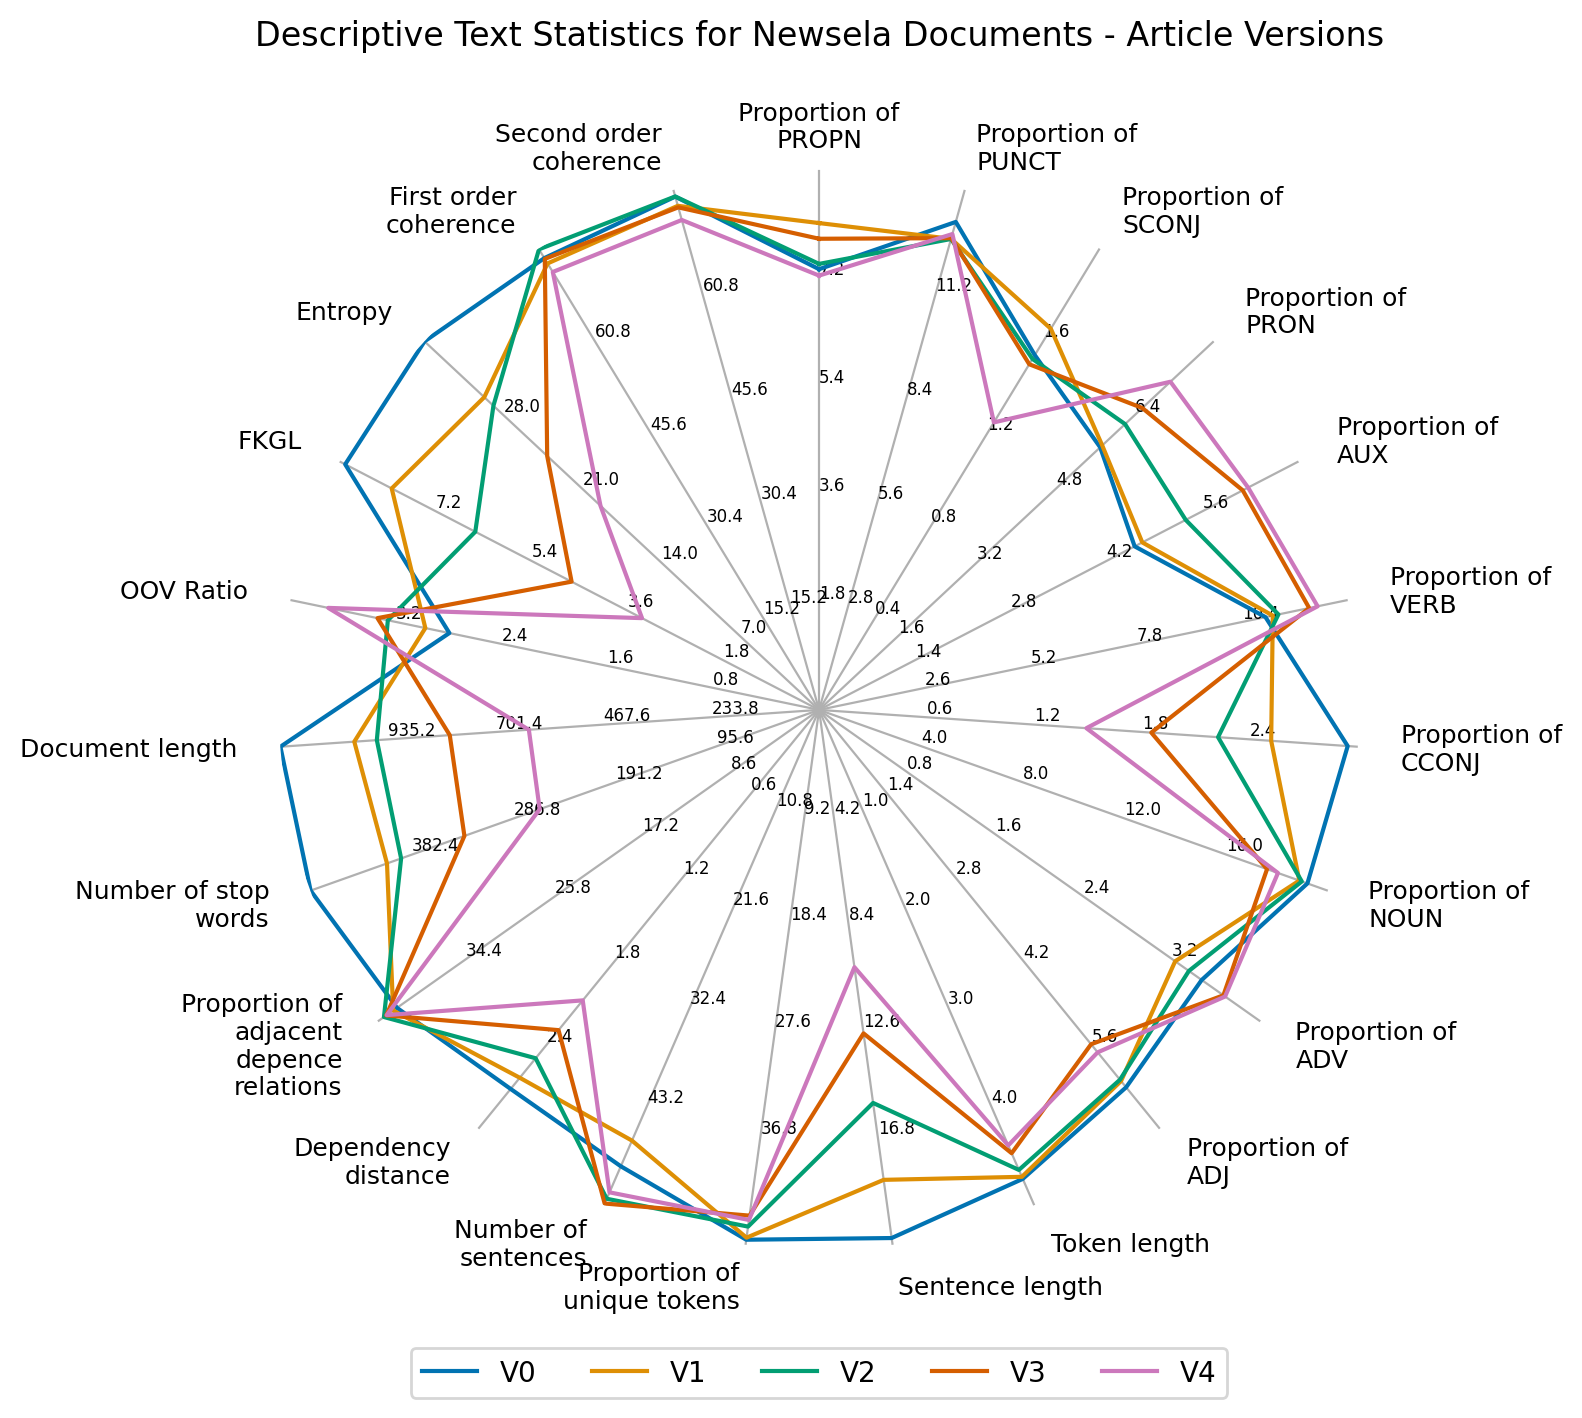

In [27]:
chart = build_radar_chart(df_v, level='V', fill=False, title='Descriptive Text Statistics for Newsela Documents - Article Versions', figsize=(6, 6), dpi=200, format_cfg=format_cfg)
# plt.savefig('plots/radar_newsela_article_versions.png', dpi=200, bbox_inches='tight')
# plt.savefig('plots/radar_newsela_article_versions.pdf', dpi=200, bbox_inches='tight')

In [7]:
# documents by version 
data_dir = '../resources/data/en/newsela_article_corpus_2016-01-29/article_documents_level'
sample_size = 50
df_l = load_data(data_dir, sample_size=sample_size, name_map=keep_cols)
df_l = df_l.reindex(df_l.index.tolist()[::-1]) # reverse order of rows to match color scheme with version chart
df_l

Computing text descriptives on level 2 (50 texts)


/home/user/kew/anaconda3/envs/simple_fudge/lib/python3.8/site-packages/textdescriptives/components/coherence.py:42: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  similarities.append(sent.similarity(sents[i + order]))


Computing text descriptives on level 3 (50 texts)


/home/user/kew/anaconda3/envs/simple_fudge/lib/python3.8/site-packages/textdescriptives/components/coherence.py:42: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  similarities.append(sent.similarity(sents[i + order]))


Computing text descriptives on level 4 (50 texts)


/home/user/kew/anaconda3/envs/simple_fudge/lib/python3.8/site-packages/textdescriptives/components/coherence.py:42: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  similarities.append(sent.similarity(sents[i + order]))


Computing text descriptives on level 5 (50 texts)


/home/user/kew/anaconda3/envs/simple_fudge/lib/python3.8/site-packages/textdescriptives/components/coherence.py:42: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  similarities.append(sent.similarity(sents[i + order]))


Computing text descriptives on level 6 (50 texts)


/home/user/kew/anaconda3/envs/simple_fudge/lib/python3.8/site-packages/textdescriptives/components/coherence.py:42: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  similarities.append(sent.similarity(sents[i + order]))


Computing text descriptives on level 7 (50 texts)


/home/user/kew/anaconda3/envs/simple_fudge/lib/python3.8/site-packages/textdescriptives/components/coherence.py:42: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  similarities.append(sent.similarity(sents[i + order]))


Computing text descriptives on level 8 (50 texts)


/home/user/kew/anaconda3/envs/simple_fudge/lib/python3.8/site-packages/textdescriptives/components/coherence.py:42: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  similarities.append(sent.similarity(sents[i + order]))


Computing text descriptives on level 9 (50 texts)


/home/user/kew/anaconda3/envs/simple_fudge/lib/python3.8/site-packages/textdescriptives/components/coherence.py:42: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  similarities.append(sent.similarity(sents[i + order]))


Computing text descriptives on level 12 (50 texts)


/home/user/kew/anaconda3/envs/simple_fudge/lib/python3.8/site-packages/textdescriptives/components/coherence.py:42: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  similarities.append(sent.similarity(sents[i + order]))


pos_prop_PROPN
pos_prop_PUNCT
pos_prop_DET
pos_prop_NOUN
pos_prop_AUX
pos_prop_VERB
pos_prop_ADP
pos_prop_PRON
pos_prop_SPACE
pos_prop_ADV
pos_prop_NUM
pos_prop_ADJ
pos_prop_PART
pos_prop_X
pos_prop_SYM
pos_prop_CCONJ
pos_prop_SCONJ
syllables_per_token_std
proportion_unique_tokens
prop_adjacent_dependency_relation_mean
prop_adjacent_dependency_relation_std
alpha_ratio
symbol_to_word_ratio_#
proportion_ellipsis
proportion_bullet_points
contains_lorem ipsum
duplicate_line_chr_fraction
duplicate_paragraph_chr_fraction
duplicate_ngram_chr_fraction_5
duplicate_ngram_chr_fraction_6
duplicate_ngram_chr_fraction_7
duplicate_ngram_chr_fraction_8
duplicate_ngram_chr_fraction_9
duplicate_ngram_chr_fraction_10
top_ngram_chr_fraction_2
top_ngram_chr_fraction_3
top_ngram_chr_fraction_4
oov_ratio
first_order_coherence
second_order_coherence
pos_prop_INTJ
Index(['Proportion of PROPN', 'Proportion of PUNCT', 'Proportion of NOUN',
       'Proportion of AUX', 'Proportion of VERB', 'Proportion of PRON',
 

,Proportion of PROPN,Proportion of PUNCT,Proportion of NOUN,Proportion of AUX,Proportion of VERB,Proportion of PRON,Proportion of ADV,Proportion of ADJ,Proportion of CCONJ,Proportion of SCONJ,...,Number of sentences,Dependency distance,Proportion of adjacent depence relations,Number of stop words,Document length,OOV Ratio,FKGL,Entropy,First order coherence,Second order coherence
level,,,,,,,,,,,,,,,,,,,,,
12,7.415593,12.432497,19.483354,4.707546,11.012336,5.559148,3.274609,6.659163,2.776085,1.712293,...,46.80,2.717299,41.404840,462.16,1128.40,2.654889,9.431579,33.209511,73.773092,73.870762
9,8.244151,12.117462,19.273301,5.019303,11.185214,5.231963,3.182073,6.586678,2.493414,1.691795,...,46.90,2.646609,41.620244,408.52,1022.96,2.952529,8.366837,29.504628,73.096865,73.306394
8,7.833691,12.684928,18.990039,4.863032,10.846467,5.875973,3.262768,6.116305,2.562551,1.669137,...,48.58,2.639810,41.839590,414.62,1025.78,3.120052,7.651033,30.285630,75.242396,74.877205
7,7.891229,12.444271,18.951662,5.135662,11.201902,5.942800,3.356229,6.495012,2.311311,1.483853,...,50.64,2.532907,42.304980,383.44,948.36,3.390560,6.951806,27.972457,75.189976,74.754970
6,7.533419,12.433108,18.764959,5.373612,11.275135,6.033752,3.655082,5.949812,2.159859,1.587312,...,53.20,2.416389,41.746069,370.32,895.38,3.296364,5.665307,26.814615,73.525801,73.317591
5,8.242033,12.637693,17.760797,5.883492,11.604167,6.225126,3.763207,5.919701,2.078178,1.391518,...,56.00,2.304902,42.486054,343.82,827.62,3.320581,4.768075,24.815251,74.710794,74.456799
4,6.979879,12.604818,17.683927,6.298628,12.243403,6.991789,3.561275,5.757218,1.722914,1.499806,...,58.62,2.143401,42.281397,318.32,739.46,3.647718,3.729980,22.704357,73.616909,72.970665
3,6.386364,12.360788,18.385224,6.501805,12.590457,7.323039,3.858791,6.105710,1.270609,1.345607,...,41.98,1.963439,42.845911,186.52,435.38,3.865479,2.522756,13.612673,73.886608,72.889778
2,8.714553,13.507843,16.440652,6.112548,12.848262,8.132715,3.863607,5.404462,0.963818,1.043567,...,42.76,1.870833,43.027316,162.64,398.94,4.394588,1.627514,12.642228,73.104139,72.226068


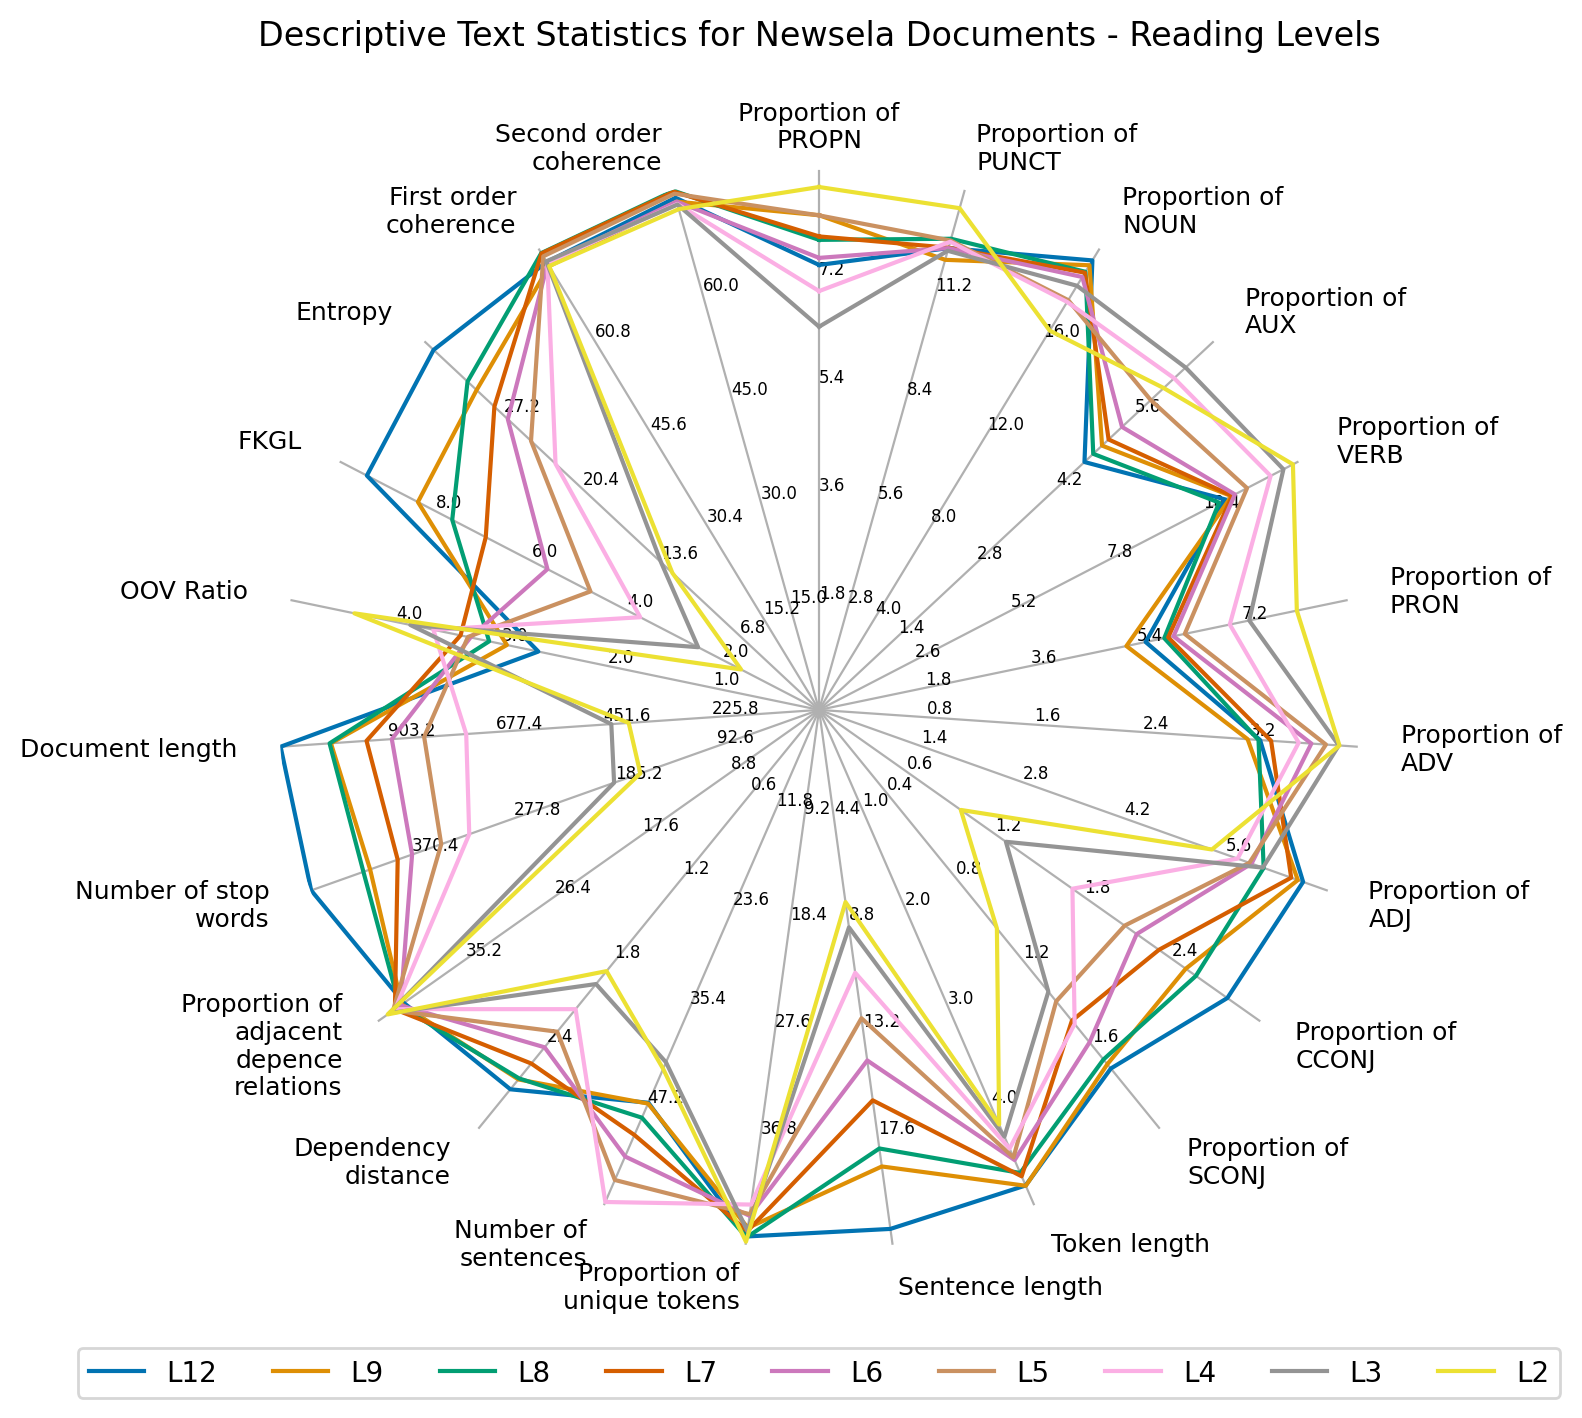

In [26]:
chart = build_radar_chart(df_l, level='L', fill=False, title='Descriptive Text Statistics for Newsela Documents - Reading Levels', figsize=(6, 6), dpi=200, format_cfg=format_cfg)
plt.savefig('plots/radar_newsela_article_levels.png', dpi=200, bbox_inches='tight')
plt.savefig('plots/radar_newsela_article_levels.pdf', dpi=200, bbox_inches='tight')

In [9]:
# # read dict lines from tsv file
# lines = iter_lines(data_dir / f'newsela_manual_{alignment_unit}_{alignment_type}' / f'{complex_level}-{simple_level}_{split}.tsv')
# # unpack complex and simple texts into separate lists
# # note: simple texts are Lists of Lists of Strings to account for multiple simple texts per complex text
# complex_texts, simple_texts = zip(*[(line['complex'], line['simple']) for line in lines])
# if len(simple_texts[0]) > 1:
#     print('WARNING: multiple simple texts per complex text, but only using first simple text...')
# simple_texts = [simple_text[0] for simple_text in simple_texts]

In [10]:
# # # get descriptive stats
# def process_texts(texts: List[str]) -> pd.DataFrame:
#     texts = clean_texts(texts)
#     df = get_descriptive_stats(get_docs(texts))
#     return df

# complex_df = process_texts(complex_texts)
# simple_df = process_texts(simple_texts)

In [11]:
# complex_df['label'] = f'v{complex_level}' if alignment_type == 'version' else f'l{complex_level}'
# simple_df['label'] = f'v{simple_level}' if alignment_type == 'version' else f'l{simple_level}'
# df = pd.concat([complex_df, simple_df])
# df.info()
# df["is_complex"] = df["label"] == f'v{complex_level}' if alignment_type == 'version' else df["label"] == f'l{complex_level}'

In [12]:
# corr = df[keep_cols.values()].corr()

# fig, ax = plt.subplots(figsize=(10, 10), sharey=False)
# sns.heatmap(corr, 
#     xticklabels=corr.columns,
#     yticklabels=corr.columns,
#     annot=True,
#     ax=ax,
#     cbar=False,
#     )

In [13]:
# # Create a PairGrid object
# sub_df = df[keep_cols[:5]+['is_complex']]
# grid = sns.PairGrid(sub_df)

# # Map a kde plot to the diagonal
# grid.map_diag(sns.kdeplot, hue=sub_df['is_complex'])

# # Map a scatter plot to the lower triangle
# grid.map_lower(sns.scatterplot)

# # Map a kde plot to the upper triangle
# grid.map_upper(sns.kdeplot, cmap="Blues_d")

# grid.add_legend()

# # Show the plot
# sns.despine()


In [14]:
# correlations = df.corrwith(df['is_complex']).sort_values(key=abs, ascending=False)
# correlations.dropna(inplace=True)
# correlations = correlations[correlations.index.isin(keep_cols)]
# print(correlations.index)
# # print(df.columns)
# # for c in correlations:
# #     print(c)

In [15]:

# for c in df.columns:
#     if c not in ['label', 'is_complex']:
#         sns.boxplot(x="label", y=c, data=df)
#         plt.show()
# sns.boxplot(x="label", y="flesch_kincaid_grade", data=df)


In [16]:
# correlations

In [17]:
# def infer_n_cols(arr: np.ndarray) -> int:
#     """
#     Infer number of columns for a 1D array of length n for visualization purposes.
#     """
#     n = len(arr)
#     if n <= 4:
#         return n
#     elif n % 5 == 0:
#         return 5
#     elif n % 4 == 0:
#         return 4
#     elif n % 3 == 0:
#         return 3
#     elif n % 2 == 0:
#         return 2

# # def infer_grid_size(arr: np.ndarray, n_cols=4) -> Tuple[int, int]:
# #     n_rows = int(np.ceil(len(arr) / n_cols))
# #     return n_rows, n_cols
    
# metrics = correlations.index.to_numpy()
# n_cols = infer_n_cols(metrics)
# metrics = metrics.reshape(-1, n_cols)
# n_rows, n_cols = metrics.shape

In [18]:
# metrics

In [19]:
# correlations

In [20]:
# grid = sns.PairGrid(df, vars=df.columns[:-1], hue='is_complex', hue_kws={'marker': ['o', 's']}, height=2, aspect=1.2)

# for i in range(metrics.shape[0]):
#     for j in range(metrics.shape[1]):
#         if metrics[i][j] != '':
#             grid.map_upper(sns.kdeplot, x=metrics[i][j], hue='is_complex', cmap="Blues_d")

In [21]:
# fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3), sharey=False, sharex=True)
# for i in range(metrics.shape[0]):
#     for j in range(metrics.shape[1]):
#         if metrics[i][j] != '' and metrics[i][j] != 'is_complex':
#             print(i, j, metrics[i][j])
#             # sns.kdeplot(df, x=metrics[i][j], hue='label', ax=ax[i,j])
#             sns.boxplot(x="label", y=metrics[i][j], data=df, ax=ax[i,j])
#         # if metric == :
#         #     continue
        
#         # sns.boxplot(y=metric, data=df)
#         # print(df[metric])
#         # 
#         # try:
#         # sns.kdeplot(df, x=metric, ax=ax[row, col])
#         # except:

#         #     pass